# Необхідні бібліотеки та функції

In [27]:
# import libraries

from IPython.display import clear_output
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar import var_model
from statsmodels.tsa.vector_ar import vecm
from statsmodels.tsa.vector_ar import svar_model
from statsmodels.tools.eval_measures import rmse, rmspe, meanabs

import plotly.graph_objects as go

In [114]:
# useful functions

def mape(y_actual, y_predicted):
    result = np.mean(np.abs((y_actual - y_predicted)/y_actual)) * 100
    return result

def change_rate(series):
    series = np.array(series)
    rate = np.diff(series, )/series[:-1] * 100
    return rate

def test_stationarity(data):
    for factor in data.columns:
        adf_test = adfuller(data[[factor]]) #use augmented Dicky-Fuller test
        print(f'{factor}: pvalue = {adf_test[1]}')
        
def plot_series(data):
    for factor in data.columns:
        plt.figure(figsize=(15, 5))
        plt.plot(data[[factor]])
        plt.title(factor)
        plt.show() 
        
def plot_inflation_predictions(first_point):    
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    preds = [first_point]
    preds_upper2stds = [first_point]
    preds_lower2stds = [first_point]
    
    preds.extend(model.mean_best_inflation_predicts)
    preds_upper2stds.extend(model.mean_best_inflation_predicts+2*model.std_best_inflation_predicts)
    preds_lower2stds.extend(model.mean_best_inflation_predicts-2*model.std_best_inflation_predicts)

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=months[:6],
                             y=data_viz['Annual Inflation Rate'],
                             line=dict(width=4, color='blue'),
                             mode='lines',
                             name='Inflation rate'))

    fig.add_trace(go.Scatter(x=months[5:],
                             y=preds_upper2stds,
                             line=dict(width=4, dash='dot', color='lightgreen'),
                             mode='lines',
                             name='Upper 2STDs'))

    fig.add_trace(go.Scatter(x=months[5:],
                             y=preds_lower2stds,
                             line=dict(width=4, dash='dot', color='lightgreen'),
                             mode='lines',
                             fill='tonexty',
                             name='Lower 2STDs'))
    
    fig.add_trace(go.Scatter(x=months[5:],
                             y=preds,
                             line=dict(width=4, dash='dash', color='blue'),
                             mode='lines',
                             name='Inflation rate forecast'))
    
    fig.update_layout(title='Прогноз темпу інфляції на кінець 2022 року', yaxis_title='Темп інфляції')
    
    fig.show()

# Завантаження та підготовка даних

In [3]:
macrodata = pd.read_csv('macrodata.csv', delimiter=';', decimal=',', encoding='windows-1251')

In [4]:
macrodata.index = pd.date_range('2013-01', '2022-10', freq='M')
macrodata.columns

Index(['Date', 'CPI', 'Annual Inflation Rate', 'UK CPI', 'US CPI', 'EU CPI',
       'Inf Expect (Households)', 'Interest Rate', 'REER', 'NEER',
       'Gross Foreign Reserves', 'Net Foreign Reserves', 'Interv',
       'Domestic Gov Bonds'],
      dtype='object')

Дані містять наступні фактори:
> CPI - Індекс споживчих цін у постійних цінах грудня 2010 року.

> Annual Inflation Rate - річна споживча інфляція (темп інфляції)

> UK CPI, US CPI, EU CPI - темпи інфляції у Великобританії, США та ЄС

> Inf Expect (Households) - інфляційні очікування домогосподарств

> Interest Rate - облікова ставка НБУ

> REER, NEER - реальний на номінальний ефективні валютні курси

> Gross Foreign Reserves - валові міжнародні резерви

> Net Foreign Reserves - чисті міжнародні резерви

> Interv - сальдо валютних інтервенцій

> Domestic Gov Bonds - середньозважена дохідність від ОВДП


In [5]:
data = macrodata.dropna().copy()
data = data.drop(['CPI', 'Date'], axis=1)
data

,Annual Inflation Rate,UK CPI,US CPI,EU CPI,Inf Expect (Households),Interest Rate,REER,NEER,Gross Foreign Reserves,Net Foreign Reserves,Interv,Domestic Gov Bonds
2016-01-31,40.2,0.3,1.4,0.3,21.5,22.0,1.03,1.03,13.29999,1.33583,-0.074300,6.25
2016-02-29,32.7,0.3,1.0,-0.1,20.5,22.0,0.94,0.94,13.44159,1.40398,-0.158800,19.80
2016-03-31,20.9,0.5,0.9,0.0,17.1,22.0,0.92,0.92,13.48950,1.55101,-0.002097,19.42
2016-04-30,9.8,0.3,1.1,-0.2,17.3,19.0,0.95,0.92,12.72151,1.03251,0.675817,18.37
2016-05-31,7.5,0.3,1.0,-0.1,15.5,18.0,0.96,0.93,13.24095,2.32642,0.332693,17.52
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-28,10.7,6.2,7.9,6.2,13.0,10.0,1.26,0.95,29.08698,18.97315,-0.307800,11.62
2022-03-31,13.7,7.0,8.5,7.8,7.6,10.0,1.30,0.95,27.55286,17.55448,-1.776200,10.96
2022-04-30,16.4,9.0,8.3,8.1,8.1,10.0,1.33,0.96,28.10745,17.56991,-2.203310,10.92
2022-05-31,18.0,9.1,8.6,8.8,13.1,10.0,1.39,0.98,26.94507,16.77922,-3.354210,10.75


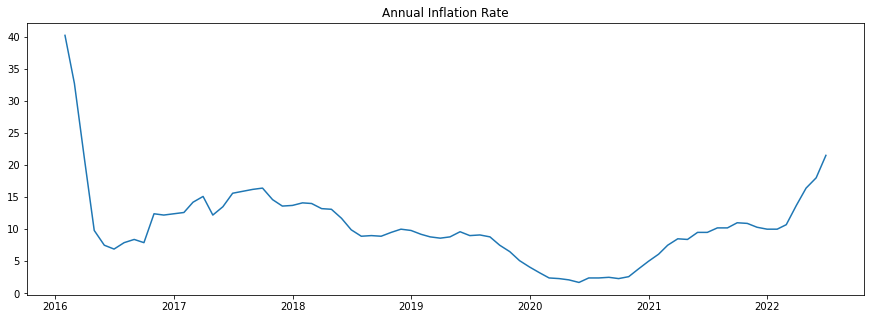

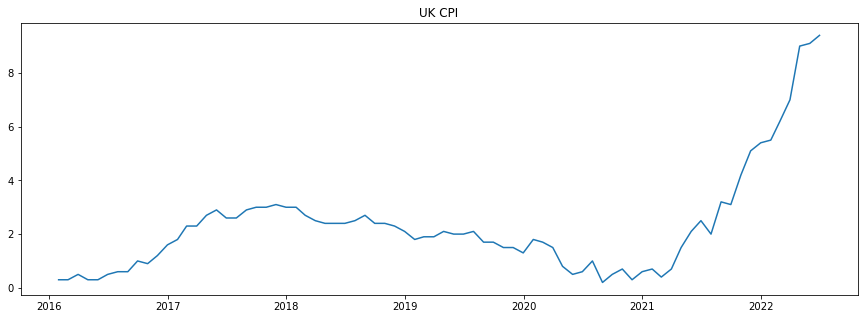

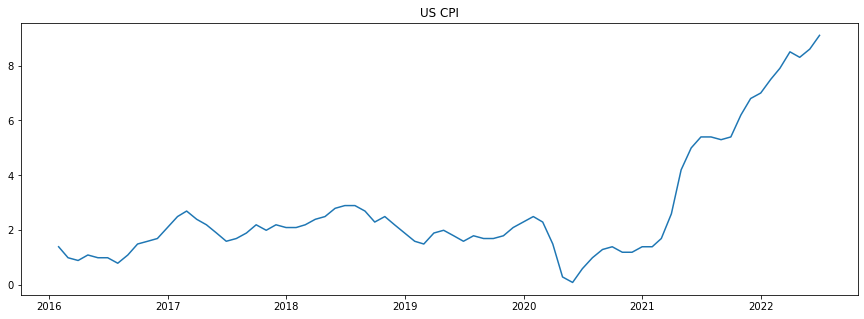

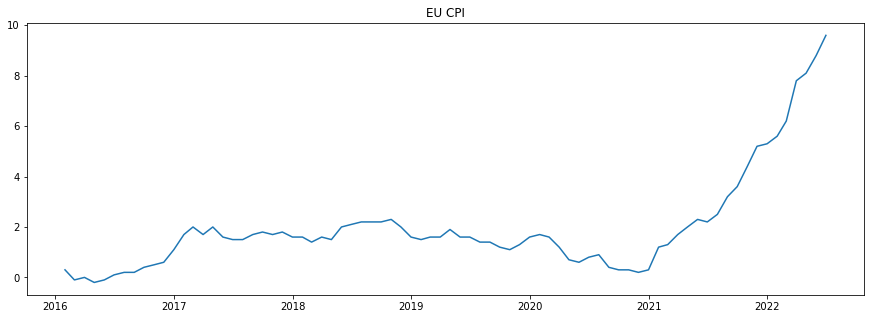

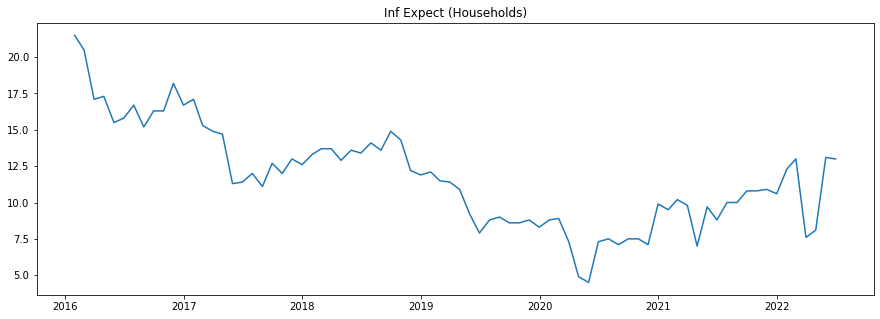

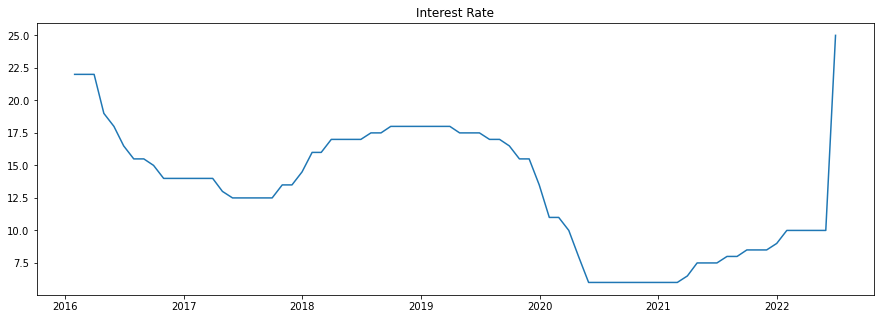

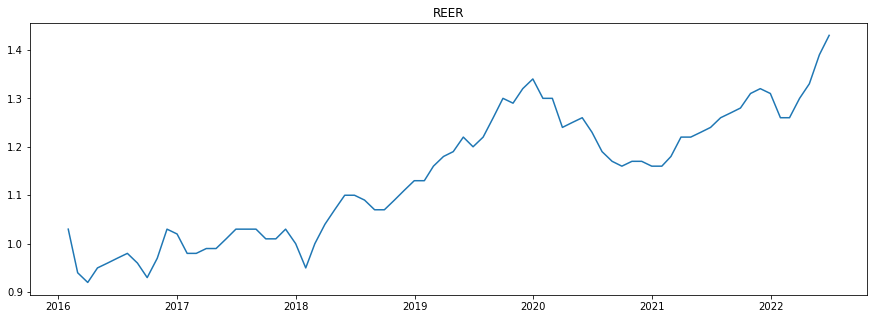

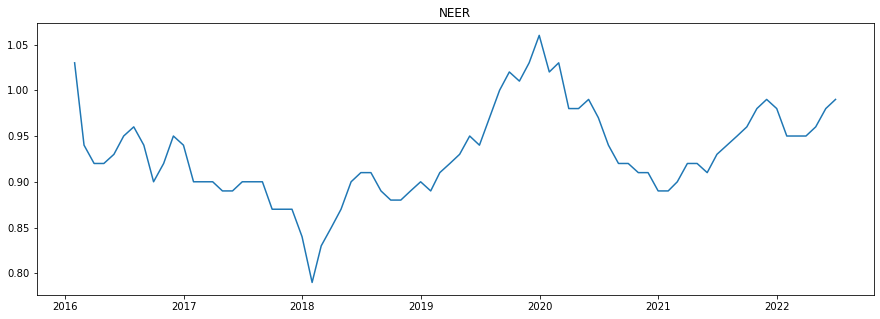

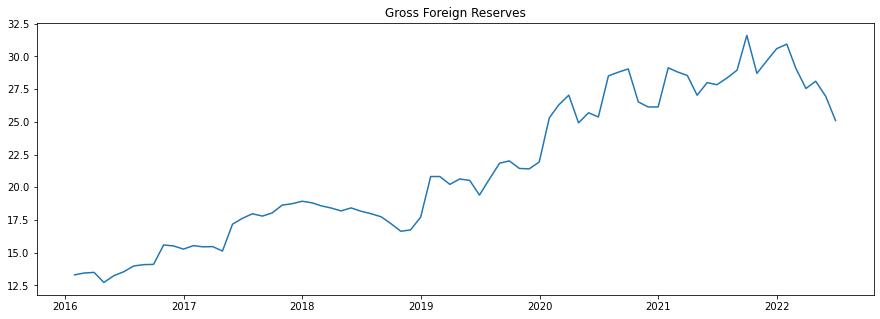

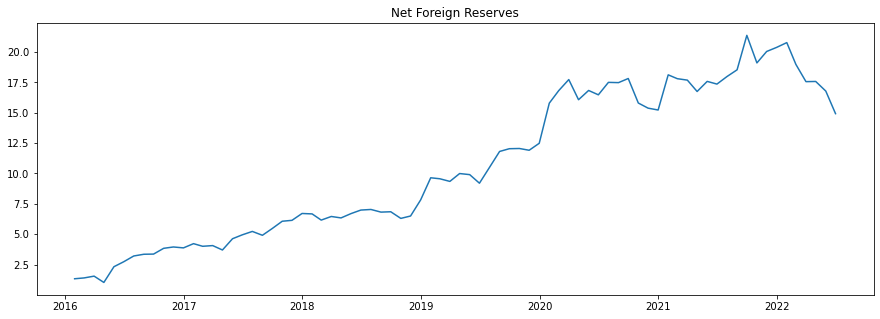

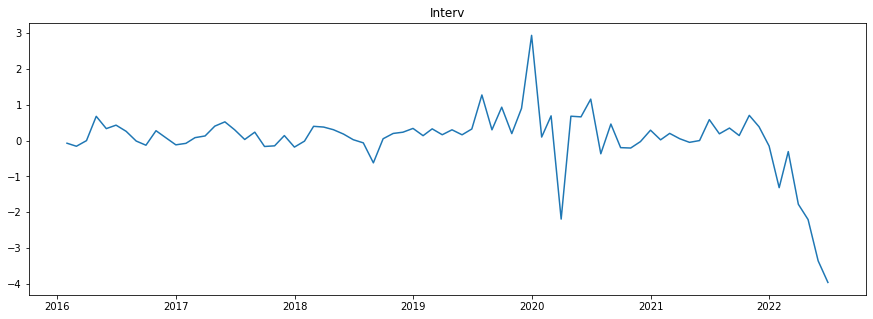

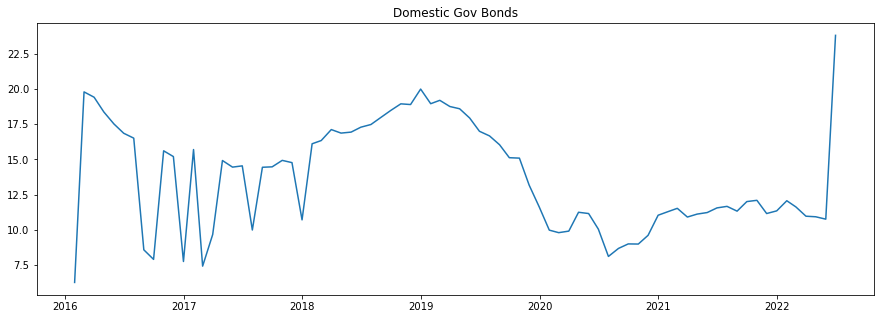

In [6]:
# plotting data

plot_series(data)

In [7]:
# stationarity testing
test_stationarity(data)

Annual Inflation Rate: pvalue = 0.8122072312103654
UK CPI: pvalue = 0.7589486283651402
US CPI: pvalue = 0.999019066643684
EU CPI: pvalue = 1.0
Inf Expect (Households): pvalue = 0.209746588103577
Interest Rate: pvalue = 0.6134987236989533
REER: pvalue = 0.8532141225046872
NEER: pvalue = 0.3246743311061132
Gross Foreign Reserves: pvalue = 0.7613291733853021
Net Foreign Reserves: pvalue = 0.7973080675114169
Interv: pvalue = 0.9978740973141208
Domestic Gov Bonds: pvalue = 0.45140375644430225


Ряди нестаціонарні

# Bagging над VECM

Нестаціонарність рядів змушує застосувати векторну модель корекції помилок (VECM). Водночас ми упираємося в фундаментальні проблеми:

1) Кількість факторів, які можна включити в модель, сильно обмежена, оскільки довжина ряду замала (див. [Прокляття розмірності](https://uk.wikipedia.org/wiki/%D0%9F%D1%80%D0%BE%D0%BA%D0%BB%D1%8F%D1%82%D1%82%D1%8F_%D1%80%D0%BE%D0%B7%D0%BC%D1%96%D1%80%D0%BD%D0%BE%D1%81%D1%82%D1%96)).

2) Попередні дані містять значну кількість нетипових значень (інфляційний шок 2014-2015 років), а тому можуть нашкодити якості моделі.

3) Складно визначити оптимальні гіперпараметри моделі (максимальний лаг, наявність тренду та/або константи в моделі і т.д.)

Необхідно обрати такий підхід, який дозволить врахувати вплив усіх обраних факторів, але при цьому залишить модель простою. Скористаємося підходом, який має назву bagging, та модифікуємо його для роботи з часовими рядами. Ідея наступна:
1) На кожній ітерації обираємо $k$ випадкових факторів.

2) Визначаємо максимальний лаг $p$.

3) У циклі для обраних факторів та лагу з проміжку від 1 до $p$ визначаємо ранг коінтеграції рядів ($r$). Якщо $r=0$, то не будуємо модель. Якщо $r \neq 0$, то робимо висновок, що ряди коінтегровані.

4) Будуємо VEC-модель з поточним лагом та визначеним рангом коінтеграції.

5) Зберігаємо результати прогнозу для інфляції та облікової ставки на 6 місяців (з липня по грудень).

6) Порівнюємо прогнози моделі з тестовими (інфляція та ставка за липень та серпень).

7) Якщо прогнози відповідають заданим критеріям точності, то зберігаємо результати прогнозу моделі як найкращі.

8) Після останньої ітерації агрегуємо прогнози багатьох моделей, окремо - прогнози лише найкращих. Для кожного місячного прогнозу визначаємо середнє, стандартне відхилення, а також верхню та нижню межу прогнозу (на рівні 2 стандартних відхилень від середнього)

Отже, замість того, щоб будувати одну сильну модель, ми будуємо велику кількість порівняно слабких, тобто застосовуємо <i>ансамблеве навчання</i>

In [116]:
# build our model
class BaggingVECM():
    
    """
    BaggingVECM class that predicts annual inflation rate and interest rate.
    Methods:
    > fit_model() -- fits BaggingVECM, makes predictions and chooses the best models
    > predict_info() -- aggregates all models, including the best, prints useful information about predictions
    """
    
    
    def __init__(self):
        pass
        
        
    def fit_model(self, data: pd.DataFrame, start_date: str,
            end_date: str, test_data: list,
            predict_periods: int,  target_factors: list=['Annual Inflation Rate', 'Interest Rate'],
            random_factors_num: int=3, maxlag: int=6, num_iter: int=500, acc: float = 1.0) -> None:
        
        """Fits BaggingVECM, makes predictions and chooses the best models. 
            data: pd.DataFrame -- data;
            start_date: str -- the first date of series, format: "YYYY-MM-DD", "MM" and "DD" are optional;
            end_date: str -- the last date of series, format: see start_date;
            test_data: list -- test data to choose the best models;
            predict_periods: int -- number of periods to predict;
            target_factors: list -- list of factors to predict;
            random_factors_num: int -- number of factors to include in each VEC model;
            maxlag: int -- the largest lag to include in the model;
            num_iter: int -- number of iterations;
            acc: float -- criterion to choose the best models."""
        
        all_factors = data.columns.drop(target_factors)
        data = data[start_date:end_date]
        
        self.inflation_predicts = []
        self.intrate_predicts = []
        self.best_inflation_predicts = []
        self.best_intrate_predicts = []
        self.best_models = []
        
        for iteration in range(num_iter):
            # select random factor(s)
            factors = target_factors.copy()
            chosen_factors = np.random.choice(all_factors, size=random_factors_num, replace=False)
            factors.extend(chosen_factors)

            print(f'Iteration #{iteration}')
            clear_output(wait=True)

            for lag in range(1, maxlag+1):
                # cointegration test
                coint_rank_test = vecm.select_coint_rank(data[factors], det_order=0, k_ar_diff=lag)
                coint_rank = coint_rank_test.rank
                if coint_rank == 0:
                    continue

                # build a model
                vecmodel = vecm.VECM(data[factors], k_ar_diff=lag, coint_rank=coint_rank, deterministic='ci')
                vecresult = vecmodel.fit()

                # predict on test data
                test_inflation_pred = vecresult.predict(len(test_data))[:, 0]
                test_intrate_pred = vecresult.predict(len(test_data))[:, 1]

                # add to all predicts
                self.inflation_predicts.append(vecresult.predict(predict_periods)[:, 0])
                self.intrate_predicts.append(vecresult.predict(predict_periods)[:, 1])

                # choose the best predicts
                inflation_abs_error = np.array(np.abs(test_data - test_inflation_pred))
                if (all(inflation_abs_error <= acc)):
                    self.best_inflation_predicts.append(vecresult.predict(predict_periods)[:, 0])
                    self.best_intrate_predicts.append(vecresult.predict(predict_periods)[:, 1])
                    self.best_models.append(vecresult)

        self.inflation_predicts = np.array(self.inflation_predicts)
        self.best_inflation_predicts = np.array(self.best_inflation_predicts)
        self.intrate_predicts = np.array(self.intrate_predicts)
        selfbest_intrate_predicts = np.array(self.best_intrate_predicts)
        self.best_models = np.array(self.best_models)

        print('Done!', f'number of selected models: {len(self.best_inflation_predicts)}')


    def predict_info(self) -> None:
        
        """Aggregates all models, including the best, prints useful information about predictions"""
        
        self.mean_inflation_predicts = np.round(np.mean(self.inflation_predicts, axis=0), 2)
        self.std_inflation_predicts = np.round(np.std(self.inflation_predicts, axis=0), 2)
        print('Inflation predicts:')
        print(f'Mean: {self.mean_inflation_predicts}')
        print(f'STD: {self.std_inflation_predicts}')
        print(f'Upper 2STDs: {self.mean_inflation_predicts + 2*self.std_inflation_predicts}')
        print(f'Lower 2STDs: {self.mean_inflation_predicts - 2*self.std_inflation_predicts} \n')
        
        self.mean_best_inflation_predicts = np.round(np.mean(self.best_inflation_predicts, axis=0), 2)
        self.std_best_inflation_predicts = np.round(np.std(self.best_inflation_predicts, axis=0), 2)
        print('***Best inflation predicts:')
        print(f'Mean: {self.mean_best_inflation_predicts}')
        print(f'STD: {self.std_best_inflation_predicts}')
        print(f'Upper 2STDs: {self.mean_best_inflation_predicts + 2*self.std_best_inflation_predicts}')
        print(f'Lower 2STDs: {self.mean_best_inflation_predicts - 2*self.std_best_inflation_predicts} \n')
        
        self.mean_intrate_predicts = np.round(np.mean(self.intrate_predicts, axis=0), 2)
        self.std_intrate_predicts = np.round(np.std(self.intrate_predicts, axis=0), 2)
        print('Interest rate predicts:')
        print(f'Mean: {self.mean_intrate_predicts}')
        print(f'STD: {self.std_intrate_predicts}')
        print(f'Upper 2STDs: {self.mean_intrate_predicts + 2*self.std_intrate_predicts}')
        print(f'Lower 2STDs: {self.mean_intrate_predicts - 2*self.std_intrate_predicts} \n')
        
        self.mean_best_intrate_predicts = np.round(np.mean(self.best_intrate_predicts, axis=0), 2)
        self.std_best_intrate_predicts = np.round(np.std(self.best_intrate_predicts, axis=0), 2)
        print('***Best interest rate predicts:')
        print(f'Mean: {self.mean_best_intrate_predicts}')
        print(f'STD: {self.std_best_intrate_predicts}')
        print(f'Upper 2STDs: {self.mean_best_intrate_predicts + 2*self.std_best_intrate_predicts}')
        print(f'Lower 2STDs: {self.mean_best_intrate_predicts - 2*self.std_best_intrate_predicts} \n')
        
        

#### Модель із врахуванням підвищення облікової ставки у червні 2022 року

In [117]:
# include intrate = 25.0% (data up to June 2022)

model = BaggingVECM()
model.fit_model(data=data, start_date='2016', end_date='2022-06', test_data=[22.2, 23.8], predict_periods=6, num_iter=2500, acc=1.5)
model.predict_info()

Done! number of selected models: 1440
Inflation predicts:
Mean: [22.04 23.74 24.12 23.45 23.6  23.73]
STD: [ 3.57  5.57  6.83  7.37  8.76 10.33]
Upper 2STDs: [29.18 34.88 37.78 38.19 41.12 44.39]
Lower 2STDs: [14.9  12.6  10.46  8.71  6.08  3.07] 

***Best inflation predicts:
Mean: [22.11 23.77 24.54 23.67 23.29 22.73]
STD: [0.87 0.84 2.2  3.09 4.9  5.56]
Upper 2STDs: [23.85 25.45 28.94 29.85 33.09 33.85]
Lower 2STDs: [20.37 22.09 20.14 17.49 13.49 11.61] 

Interest rate predicts:
Mean: [28.24 28.83 33.47 36.69 40.94 45.57]
STD: [3.6  5.51 5.57 6.71 7.53 9.72]
Upper 2STDs: [35.44 39.85 44.61 50.11 56.   65.01]
Lower 2STDs: [21.04 17.81 22.33 23.27 25.88 26.13] 

***Best interest rate predicts:
Mean: [28.84 28.05 32.32 35.4  39.73 45.2 ]
STD: [3.11 4.89 4.94 5.3  4.7  6.45]
Upper 2STDs: [35.06 37.83 42.2  46.   49.13 58.1 ]
Lower 2STDs: [22.62 18.27 22.44 24.8  30.33 32.3 ] 



#### Модель без врахування підвищення облікової ставки у червні 2022 року

In [25]:
#exclude intrate=25% (data up to May 2022)

model_2 = BaggingVECM()
model_2.fit_model(data=data, start_date='2016', end_date='2022-05', test_data=[21.5, 22.2], predict_periods=7, num_iter=2500, acc=1.5)
model_2.predict_info()

Done! number of selected models: 913
Inflation predicts:
Mean: [18.84 20.14 21.4  21.98 22.38 23.08 23.82]
STD: [1.11 2.18 3.52 4.67 5.7  6.82 7.93]
Upper 2STDs: [21.06 24.5  28.44 31.32 33.78 36.72 39.68]
Lower 2STDs: [16.62 15.78 14.36 12.64 10.98  9.44  7.96] 

***Best inflation predicts:
Mean: [20.38 22.54 24.57 25.68 26.31 26.95 27.39]
STD: [0.33 0.74 1.69 2.39 3.1  3.8  4.39]
Upper 2STDs: [21.04 24.02 27.95 30.46 32.51 34.55 36.17]
Lower 2STDs: [19.72 21.06 21.19 20.9  20.11 19.35 18.61] 

Interest rate predicts:
Mean: [10.34 10.59 10.86 11.31 11.52 11.81 12.17]
STD: [0.57 0.93 1.3  1.91 2.55 3.23 3.91]
Upper 2STDs: [11.48 12.45 13.46 15.13 16.62 18.27 19.99]
Lower 2STDs: [9.2  8.73 8.26 7.49 6.42 5.35 4.35] 

***Best interest rate predicts:
Mean: [10.54 10.83 11.5  12.41 13.18 13.83 14.38]
STD: [0.43 0.78 1.18 1.85 2.61 3.44 4.19]
Upper 2STDs: [11.4  12.39 13.86 16.11 18.4  20.71 22.76]
Lower 2STDs: [9.68 9.27 9.14 8.71 7.96 6.95 6.  ] 



Бачимо, що без підвищення відсоткової ставки модель прогнозує значне зростання інфляції до 27.xx% у грудні 2022 року. З урахуванням підвищення відсоткової ставки модель прогнозує зменшення темпів інфляції у IV кварталі 2022 року. Хоча модель не можна використовувати для прогнозування облікової ставки, з порівняння прогнозів інфляції для обох моделей можна зробити висновок, що підвищення облікової ставки до 25% дозволяє стримати і навіть знизити темпи інфляції в кінці року.

In [196]:
plot_inflation_predictions(first_point=21.5)

Беґґінг на векторними моделями корекції помилок дозволяє робити непоганий прогноз інфляції, проте не дозволяє інтерпретувати та проаналізувати модель. Щоб це було можливим, можна обрати з найкращих моделей ту, прогнози котрої найменше відхиляються від середнього прогнозу.

In [214]:
def choose_best_model(models, predict_period: int=6):
    forecasts = []
    for model_ in models:
        forecasts.append(model_.predict(predict_period)[:, 0])
        
    mean_forecasts = np.mean(forecasts, axis=0)
    deviations = []
    for forecast in forecasts:
        deviation = meanabs(mean_forecasts, forecast)
        deviations.append(deviation)
    
    best_model = models[np.argmin(deviations)]
    return best_model


In [215]:
best_model = choose_best_model(model.best_models)
print(f'Factors of the best model: {best_model.names}')
#best_model.irf().plot(figsize=(20,20))

Factors of the best model: ['Annual Inflation Rate', 'Interest Rate', 'REER', 'Interv', 'EU CPI']


In [216]:
print(f'Forecasts of the best model: {np.round(best_model.predict(6)[:, 0], 2)}')
print(f'Mean forecasts: {model.mean_best_inflation_predicts}')

Forecasts of the best model: [22.48 23.77 25.45 24.17 23.09 23.12]
Mean forecasts: [22.11 23.77 24.54 23.67 23.29 22.73]


Проаналізуємо дану модель, провівши тест Ґренджера на причинність та дослідивши функції імпульсного відгуку, щоб дізнатися реакцію факторів моделі на шоки відсоткової ставки.

In [217]:
print(best_model.test_granger_causality('Annual Inflation Rate', 'Interest Rate').summary())
print(best_model.test_granger_causality('Annual Inflation Rate', 'Interv').summary())

Granger causality F-test. H_0: Interest Rate does not Granger-cause Annual Inflation Rate. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         1.353          2.073   0.230 (7, 145)
----------------------------------------------
Granger causality F-test. H_0: Interv does not Granger-cause Annual Inflation Rate. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         2.134          2.073   0.044 (7, 145)
----------------------------------------------


Зміни відсоткової ставки не спричиняють (за Ґренджером) короткострокових змін темпу інфляції, але зміни сальдо валютних інтервенцій - спричиняють.

In [218]:
print(best_model.test_granger_causality('REER', 'Interest Rate').summary())
print(best_model.test_granger_causality('Interv', 'Interest Rate').summary())
print(best_model.test_granger_causality('EU CPI', 'Interest Rate').summary())

Granger causality F-test. H_0: Interest Rate does not Granger-cause REER. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         11.33          2.073   0.000 (7, 145)
----------------------------------------------
Granger causality F-test. H_0: Interest Rate does not Granger-cause Interv. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         3.302          2.073   0.003 (7, 145)
----------------------------------------------
Granger causality F-test. H_0: Interest Rate does not Granger-cause EU CPI. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         2.139          2.073   0.043 (7, 145)
----------------------------------------------


Зміни відсоткової ставки в короткому періоді можуть викликати зміни реального ефективного валютного курсу, сальдо валютних інтервенцій та темпу інфляції в ЄС.

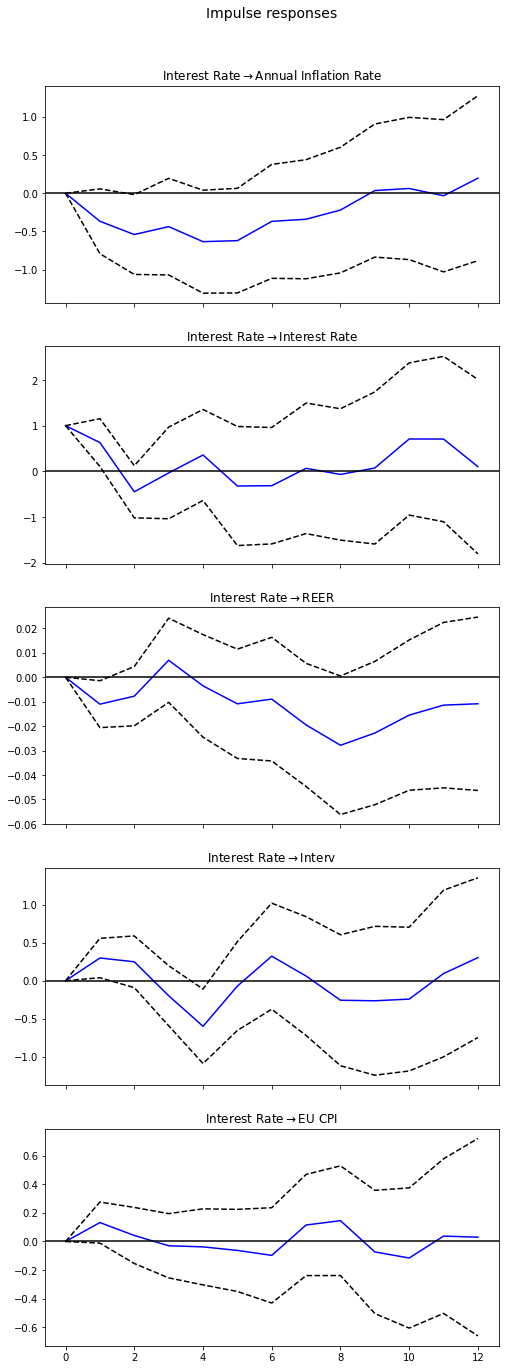

In [219]:
irf = best_model.irf(periods=12)
irf.plot(figsize=(7, 20), impulse='Interest Rate')
plt.show()

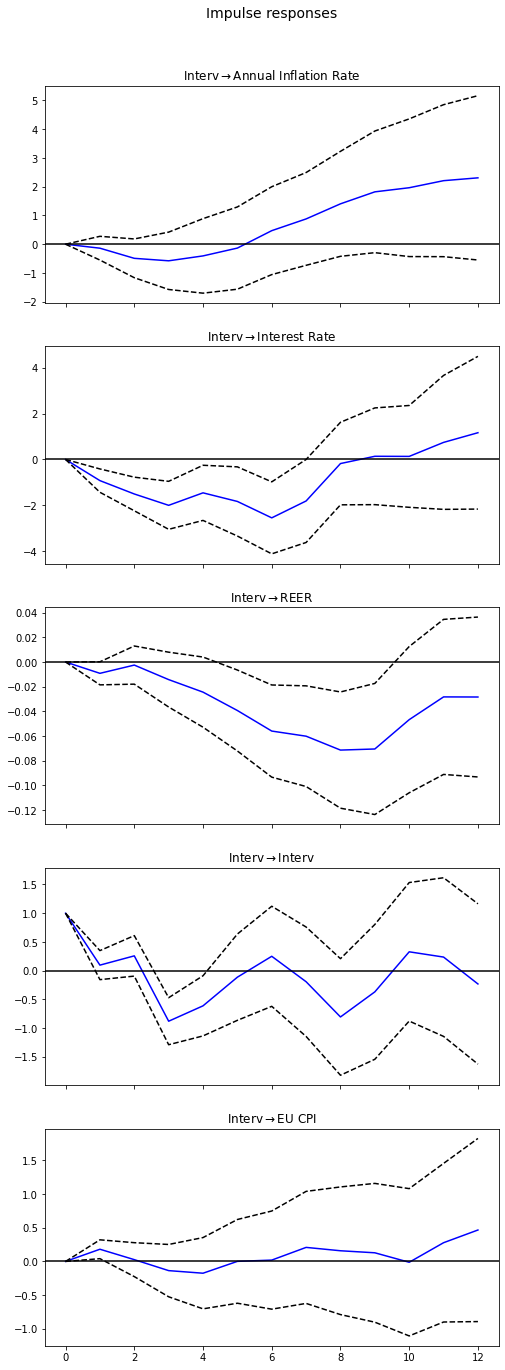

In [220]:
irf.plot(figsize=(7, 20), impulse='Interv')
plt.show()